In [2]:
# GIS imports
import rasterio
from rasterio.plot import show
import geopandas as gpd
from rasterio.mask import mask
from rasterio import features

from shapely.geometry import box
import shapely
from shapely import Polygon

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib.patches import Ellipse
import matplotlib.image as image

# Misc imports
import json
from datetime import datetime, timedelta
from pathlib import Path
import numpy as np
import os

In [3]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

This notebook requires OPERA DSWx-HLS data to be mosaicked first, which is done by other code in the parent folder

In [4]:
# if running notebook to create a large number of plots, set this flag to True
SAVE_PLOT_MODE = False
plotting_path = Path('../plots_b03/')
if SAVE_PLOT_MODE:
    plotting_path.mkdir(exist_ok=True)

In [5]:
# This is the path where we have created merged B01 OPERA DSWx data
b01_data_path = Path('../data/B01_mosaics/')
year_paths = [x for x in b01_data_path.glob('20*') if x.is_dir()]

b01_filepaths = []
for p_ in sorted(year_paths):
    b01_filepaths.extend(sorted(list(p_.glob('*.tif'))))

In [6]:
# This is the path where we have created merged B03 OPERA DSWx data
data_path = Path('../data/B03_mosaics/')
year_paths = [x for x in data_path.glob('20*') if x.is_dir()]

filepaths = []
for p_ in sorted(year_paths):
    filepaths.extend(sorted(list(p_.glob('*.tif'))))

In [7]:
# Obtain the shapefile corresponding to the maximum fill level of Lake Mead
with rasterio.open(filepaths[0]) as ds:
    lake_mead_df = gpd.read_file('../data/lakebnds/lakebnds.shp').to_crs(ds.crs)
    lake_mead_geom = lake_mead_df.dissolve()

In [ ]:
# Filter dates by cloud cover. We would like images that have less than 5% cloud cover
def filter_cloud_cover(filepath):
    date = datetime_obj = datetime.strptime(filepath.stem, "%Y%m%d")
    inset_box_bounds = 7.26e5, 4.0165e6, 7.413e5, 4.038e6

    # read area within lake mead shape
    with rasterio.open(filepath) as ds:
        sample_transform = ds.transform
        
        # read entire Lake area
        img, _ = mask(ds, [lake_mead_geom.iloc[0].geometry])
        
        # read only inset area
        img2, _ = mask(ds, [shapely.Polygon.from_bounds(*inset_box_bounds)])
        img2 = np.where(img2<255, 1, 255)

    # mask out areas outside region of interest
    img_aoi = np.where((img<255) & (img2 < 255), img, 255)

    valid_pixels = np.sum(img_aoi != 255).astype(float)
    cloud_pixels = np.sum(img_aoi==253)

    cloud_fraction = cloud_pixels/valid_pixels

    return cloud_fraction < 0.05

valid_images = list(filter(filter_cloud_cover, b01_filepaths))

In [ ]:
# calculate the area of the northern portion of the lake (defined by the bounding box)
def calculate_area(filepath):
    date = datetime_obj = datetime.strptime(filepath.stem, "%Y%m%d")
    inset_box_bounds = 7.26e5, 4.0165e6, 7.413e5, 4.038e6

    # read area within lake mead shape
    with rasterio.open(filepath) as ds:
        sample_transform = ds.transform
        
        # read entire Lake area
        img, _ = mask(ds, [lake_mead_geom.iloc[0].geometry])
        
        # read only inset area
        img2, _ = mask(ds, [shapely.Polygon.from_bounds(*inset_box_bounds)])
        img2 = np.where(img2<255, 1, 255)

    # mask out areas outside region of interest
    img_aoi = np.where((img<255) & (img2 < 255), img, 255)

    return date, 9e-4*np.sum(np.where((img_aoi>0) & (img_aoi < 2), True, False))

date_area = list(map(calculate_area, valid_images))
dates = [x[0] for x in date_area]
areas = [x[1] for x in date_area]

In [9]:
# The Lake Mead gauge data is obtained from this link: https://www.usbr.gov/lc/region/g4000/riverops/_HdbWebQuery.html
# the data is provided as a json file, which can be loaded into a dictionary and subsequently parsed

def parse_dict(input_dict):
    datestr = input_dict['t']
    month, day, year = [int(x) for x in datestr.split(" ")[0].split("/")]
    
    date = datetime(year=year, month=month, day=day)
    water_level = float(input_dict['v'])

    return date, water_level

In [10]:
# Parse gauge data

data_file = Path('../data/accumweb_10092023.json')

with open(data_file, 'r') as f:
    data = json.load(f)

dataset = list(map(parse_dict, data['Series'][0]['Data'][:-1])) # the last data entry has a null value for water level, we skip this

x = [entry[0] for entry in dataset]
y = [entry[1] for entry in dataset]

In [11]:
# We have created an HLS mosaic to serve as our basemap
with rasterio.open('../data/hls/2022185_hls_mosaic.tif') as ds:
    hls_mosaic_img = ds.read()

print(hls_mosaic_img.shape)

(3, 6994, 6992)


/var/folders/0j/_hzqdqys6wg5g5khfdl7tdk00000gr/T/ipykernel_8177/3692782492.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, fontsize=30, color='white')


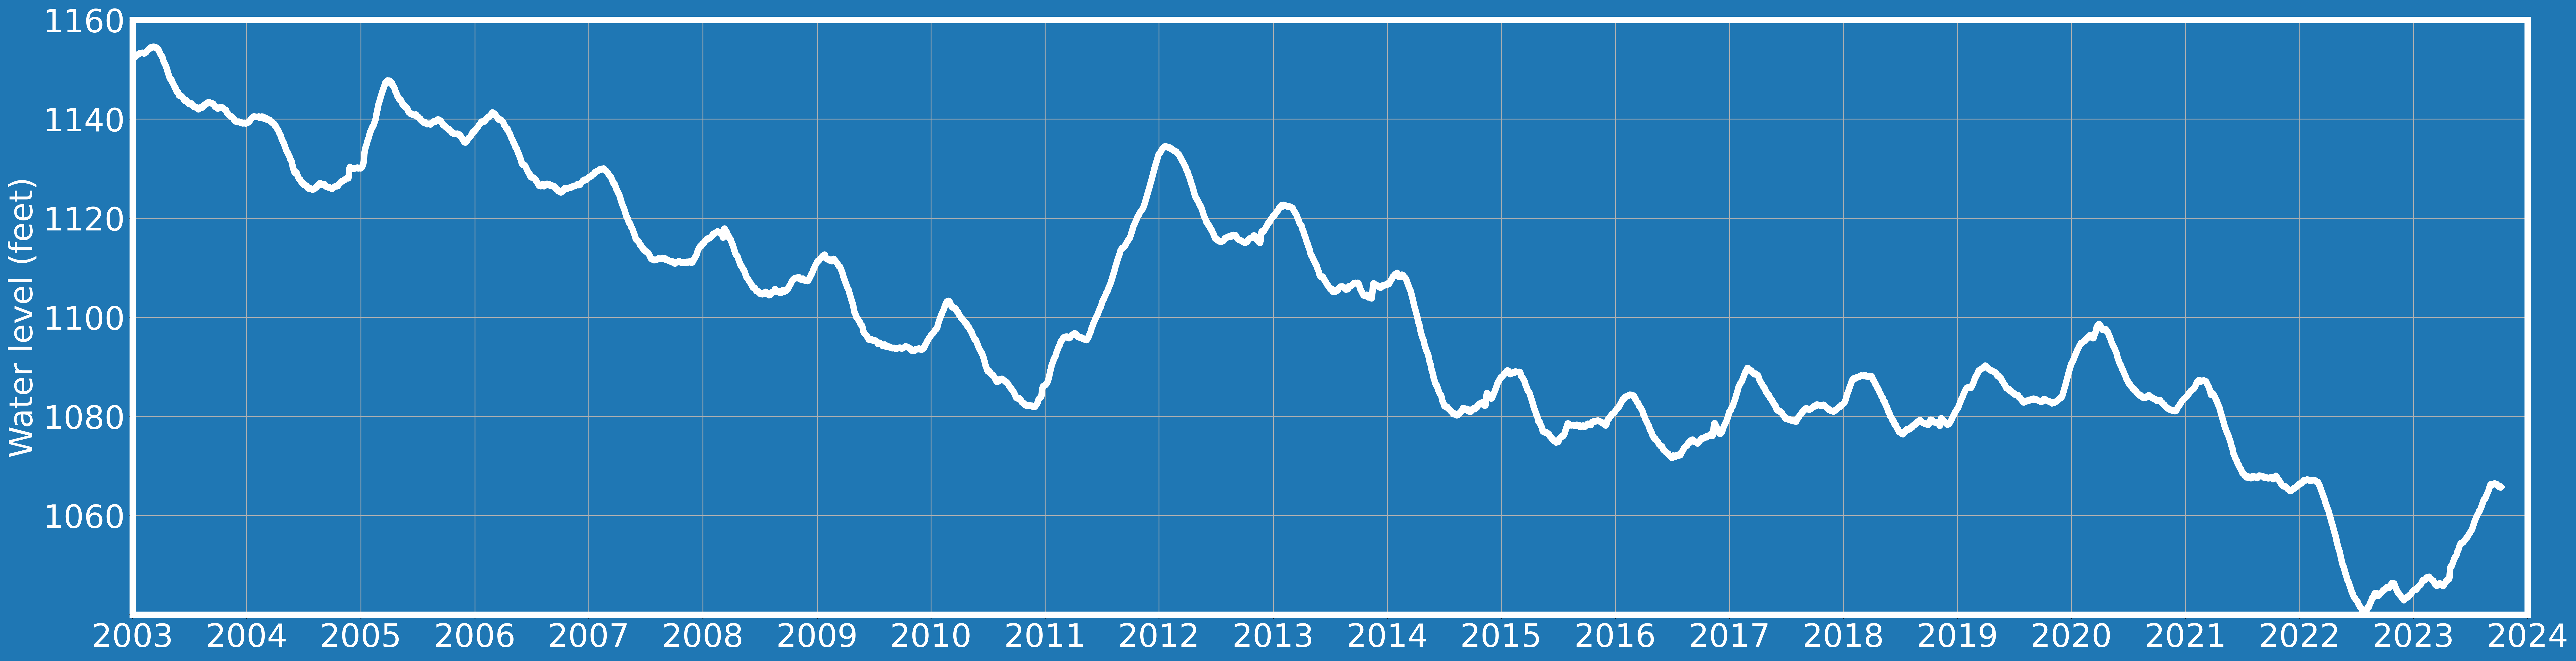

In [12]:
plt.plot(x, y, linewidth=6, color='white')
ax = plt.gca()
fig = plt.gcf()
fig.set_dpi(300)
fig.set_size_inches(40, 10)
# fig.figsize(20, 10)
# ax.plot(x, y, linewidth=6, color='white')
# ax.set_aspect('0.7')
ax.set_xlim(datetime(year=2003, month=1, day=1), datetime(year=2024, month=1, day=1))
ax.set_ylim([1040, 1160])
ax.set_ylabel("Water level (feet)", fontsize=30, color='white')
ax.grid()

ylims = ax.get_ylim()
yticks = [int(x) for x in ax.get_yticks()]
yticks[0]=""
ax.set_xticks([datetime(year=x, month=1, day=1) for x in range(2003, 2025)])
ax.set_xticklabels([datetime(year=x, month=1, day=1).strftime("%Y") for x in range(2003, 2025)], fontsize=30, color='white')

ax.set_yticklabels(yticks, fontsize=30, color='white')
ax.set_facecolor('tab:blue')
fig.set_facecolor('tab:blue')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(6)
    ax.spines[axis].set_color('white')

In [ ]:
def create_lineplot(filename):

    filename = Path(str(filename).replace("B01_mosaics", "B03_mosaics"))
    if not filename.exists():
        return

    fig, ax = plt.subplots(1, 1, figsize=(40, 10))
    fig.set_dpi(300)

    yyyymmdd = filename.with_suffix('').name
    year = int(yyyymmdd[:4])
    month = int(yyyymmdd[4:6])
    day = int(yyyymmdd[6:])

    date = datetime(year=year, month=month, day=day)
    
    output_filename = f"{filename.stem}.png"
    ax.plot(x, y, linewidth=6, color='white')
    ax.set_xlim(datetime(year=2014, month=1, day=1), datetime(year=2024, month=1, day=1))
    ax.set_ylim([1030, 1120])
    ax.set_ylabel("Water level (feet)", fontsize=30, color='white')
    ax.grid()

    water_level = y[np.where([x_ == date for x_ in x])[0][0]]

    ylims = ax.get_ylim()
    yticks = [int(x) for x in ax.get_yticks()]
    yticks[0]=""
    ax.set_xticks([datetime(year=x, month=1, day=1) for x in range(2014, 2025)])
    ax.set_xticklabels([datetime(year=x, month=1, day=1).strftime("%Y") for x in range(2014, 2025)], fontsize=30, color='white')

    ax.set_yticklabels(yticks, fontsize=30, color='white')
    ax.set_facecolor('tab:blue')
    fig.set_facecolor('tab:blue')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(6)
        ax.spines[axis].set_color('white')

    ax.plot([date, date], ylims, color = 'red', linewidth=4)
    ax.annotate(f"{water_level} ft.", xy=(min(date+timedelta(days=80), datetime(year=2023, month=6, day=1)), max(water_level-25, 1050)), fontsize=24, color='white', weight="bold")
    ax.add_artist(Ellipse((date, water_level), 30, 3, edgecolor="black", fill=False, linewidth=3, zorder=3)) # circle marker to indicate location of intersection

    ax.spines['right'].set_color('cyan')
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'cyan'
    ax2.set_ylabel('Water extent area (km$^2)$', color=color, fontsize=30)
    ax2.scatter(dates, areas, color=color, s=100)
    ax2.plot(dates, areas, color=color, linestyle='dashed', alpha=0.4)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=30)
    yticks = [int(x) for x in ax2.get_yticks()]
    yticks[0]=""
    ax2.set_yticklabels(yticks)
    ax2.set_ylim([0, 60])
    

    plt.savefig(f'../images/line_plots/time_series_final/{output_filename}')
    plt.close()

_ = list(map(create_lineplot, valid_images))

In [ ]:
# We need shapefile for 2014 for reference
filename = valid_images[0]
filename = Path(str(filename).replace("B01_mosaics", "B03_mosaics"))

with rasterio.open(filename) as ds:
    src_crs = ds.crs
    sample_bounds = ds.bounds
    sample_transform = ds.transform
    colormap = ds.colormap(1)
    img, _ = mask(ds, [lake_mead_geom.iloc[0].geometry]) # ds.read(1)

masked_img = np.zeros_like(img) 
for val in [1, 2, 3, 11, 12, 13]:
    masked_img[img == val] = 1

shapes = features.shapes(masked_img, mask=masked_img, transform=sample_transform)
shapes = [s for s in shapes]
gdf = gpd.GeoDataFrame(geometry=[Polygon(s[0]['coordinates'][0]) for s in shapes] , crs=src_crs)
lake_mead_2014 = gpd.GeoDataFrame(geometry = [gdf.geometry.unary_union], crs=src_crs)

In [ ]:
# We also need the shapefile for 2023 for reference
filename = valid_images[-1]
filename = Path(str(filename).replace("B01_mosaics", "B03_mosaics"))

with rasterio.open(filename) as ds:
    src_crs = ds.crs
    sample_bounds = ds.bounds
    sample_transform = ds.transform
    colormap = ds.colormap(1)
    img, _ = mask(ds, [lake_mead_geom.iloc[0].geometry]) # ds.read(1)

masked_img = np.zeros_like(img) 
for val in [1, 2, 3, 11, 12, 13]:
    masked_img[img == val] = 1

shapes = features.shapes(masked_img, mask=masked_img, transform=sample_transform)
shapes = [s for s in shapes]
gdf = gpd.GeoDataFrame(geometry=[Polygon(s[0]['coordinates'][0]) for s in shapes] , crs=src_crs)
lake_mead_2023 = gpd.GeoDataFrame(geometry = [gdf.geometry.unary_union], crs=src_crs)

In [ ]:
def generate_plots(filename):
    hex_color = "#3dc5fc"

    inset_box_bounds = 7.26e5, 4.0165e6, 7.413e5, 4.038e6

    filename = Path(str(filename).replace("B01_mosaics", "B03_mosaics"))
    if not filename.exists():
        return

    with rasterio.open(filename) as ds:
        src_crs = ds.crs
        sample_bounds = ds.bounds
        sample_transform = ds.transform
        colormap = ds.colormap(1)
        img, _ = mask(ds, [lake_mead_geom.iloc[0].geometry]) # ds.read(1)

    # We want to see only OSW and PSW - set opacity of all other classes to zero
    # Also change PSW to match OSW color scheme
    for key, val in colormap.items():

        # turn all useful water data into same color
        if key in [1, 2, 3, 11, 12, 13]: # 
            colormap[key] = (56, 189, 250, 255)

        # turn the opacity of all other classes to zero
        else:
            val = list(val)
            val[3] = 0
            colormap[key] = tuple(val)

    cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

    # parse date
    yyyymmdd = filename.with_suffix('').name
    year = int(yyyymmdd[:4])
    month = int(yyyymmdd[4:6])
    day = int(yyyymmdd[6:])

    output_filename = f"{filename.stem}.png"

    date = datetime(year=year, month=month, day=day)

    fig, axs = plt.subplots(1, 1, figsize=(10, 20))
    
    ## VERTICAL PANEL
    ### Plot zoomed inset
    x1, x2, y1, y2 = inset_box_bounds[0], inset_box_bounds[2], inset_box_bounds[1], inset_box_bounds[3]

    show(hls_mosaic_img*3e-4, ax=axs, transform=sample_transform)
    show(img, ax=axs, cmap=cmap, transform=sample_transform)
    axs.set_xlim([x1, x2])
    axs.set_ylim([y1, y2])
    axs.set_xticks([])
    axs.set_yticks([])

    axs.annotate(f"{date.strftime('%d %B %Y')}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=30, color='black', weight='bold')
    
    scalebar = AnchoredSizeBar(axs.transData,
                            3000, '3 km', 'lower left', 
                            color='white',
                            frameon=False,
                            pad = 0.25,
                            sep=5,
                            fontproperties = {'weight':'semibold', 'size':25},
                            size_vertical=100)
    axs.add_artist(scalebar)
    lake_mead_geom.plot(ax=axs, facecolor="none", edgecolor="purple", linewidth=2) # linestyle='--'
    
    plt.tight_layout()
    
plt.ion()
_ = list(map(generate_plots, valid_images[:1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

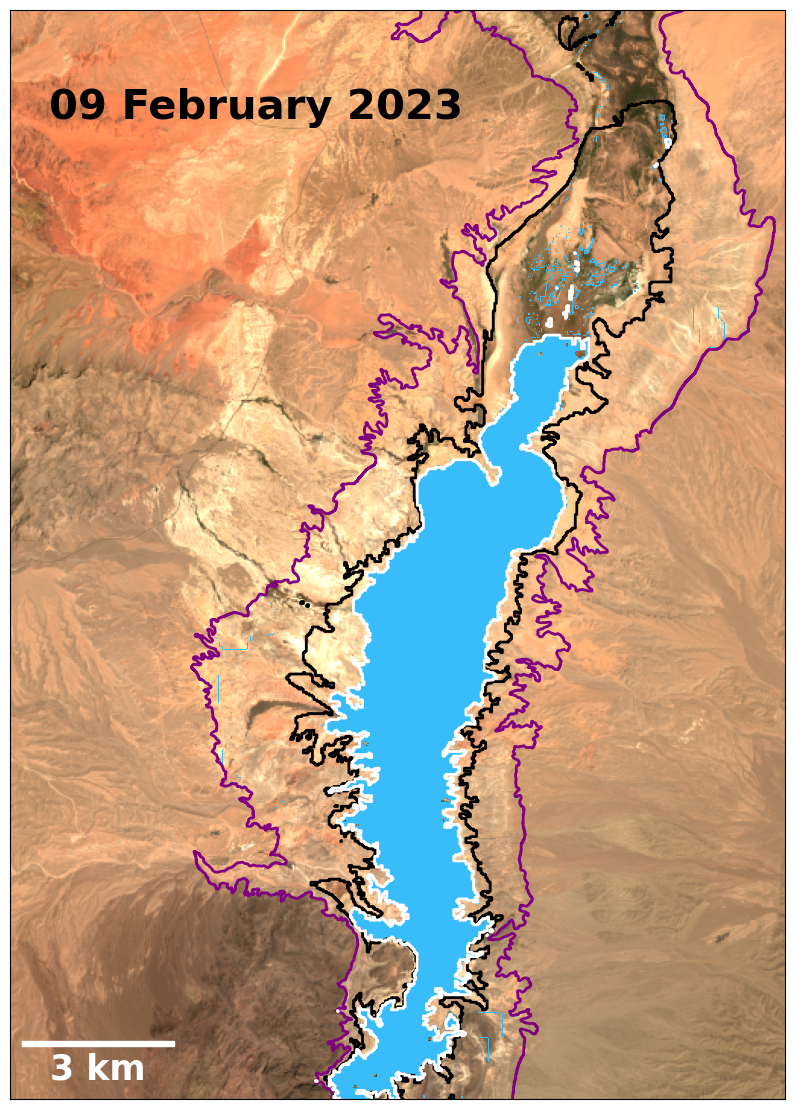

In [20]:
filename = valid_images[-1]

hex_color = "#3dc5fc"

inset_box_bounds = 7.26e5, 4.0165e6, 7.413e5, 4.038e6

filename = Path(str(filename).replace("B01_mosaics", "B03_mosaics"))

with rasterio.open(filename) as ds:
    src_crs = ds.crs
    sample_bounds = ds.bounds
    sample_transform = ds.transform
    colormap = ds.colormap(1)
    img, _ = mask(ds, [lake_mead_geom.iloc[0].geometry]) # ds.read(1)

masked_img = np.zeros_like(img) 
for val in [1, 2, 3, 11, 12, 13]:
    masked_img[img == val] = 1

for key, val in colormap.items():
    if key in [1, 2, 3, 11, 12, 13]: # 
        colormap[key] = (56, 189, 250, 255)

    # turn the opacity of all other classes to zero
    else:
        val = list(val)
        val[3] = 0
        colormap[key] = tuple(val)

cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

# parse date
yyyymmdd = filename.with_suffix('').name
year = int(yyyymmdd[:4])
month = int(yyyymmdd[4:6])
day = int(yyyymmdd[6:])

output_filename = f"{filename.stem}.png"

date = datetime(year=year, month=month, day=day)

fig, axs = plt.subplots(1, 1, figsize=(10, 20))

### Plot zoomed inset
x1, x2, y1, y2 = inset_box_bounds[0], inset_box_bounds[2], inset_box_bounds[1], inset_box_bounds[3]

show(hls_mosaic_img*3e-4, ax=axs, transform=sample_transform)
show(img, ax=axs, cmap=cmap, transform=sample_transform)
axs.set_xlim([x1, x2])
axs.set_ylim([y1, y2])
axs.set_xticks([])
axs.set_yticks([])

axs.annotate(f"{date.strftime('%d %B %Y')}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=30, color='black', weight='bold')

scalebar = AnchoredSizeBar(axs.transData,
                        3000, '3 km', 'lower left', 
                        color='white',
                        frameon=False,
                        pad = 0.25,
                        sep=5,
                        fontproperties = {'weight':'semibold', 'size':25},
                        size_vertical=100)
axs.add_artist(scalebar)
lake_mead_geom.plot(ax=axs, facecolor="none", edgecolor="purple", linewidth=2)
lake_mead_2014.plot(ax=axs, facecolor="none", edgecolor = "black", linewidth=2)
lake_mead_2023.plot(ax=axs, facecolor="none", edgecolor = "white", linewidth=2)

In [ ]:
def generate_inset_plot(filename):

    hex_color = "#3dc5fc"

    inset_box_bounds = 7.26e5, 4.0165e6, 7.413e5, 4.038e6

    filename = Path(str(filename).replace("B01_mosaics", "B03_mosaics"))
    if not filename.exists():
        print(f"Filename does not exist: {filename}")
        return

    with rasterio.open(filename) as ds:
        src_crs = ds.crs
        sample_bounds = ds.bounds
        sample_transform = ds.transform
        colormap = ds.colormap(1)
        img, _ = mask(ds, [lake_mead_geom.iloc[0].geometry]) # ds.read(1)

    for key, val in colormap.items():
        if key in [1, 2, 3, 11, 12, 13]: # 
            colormap[key] = (56, 189, 250, 255)

        # turn the opacity of all other classes to zero
        else:
            val = list(val)
            val[3] = 0
            colormap[key] = tuple(val)

    cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

    # parse date
    yyyymmdd = filename.with_suffix('').name
    year = int(yyyymmdd[:4])
    month = int(yyyymmdd[4:6])
    day = int(yyyymmdd[6:])

    output_filename = f"{filename.stem}.png"

    date = datetime(year=year, month=month, day=day)

    fig, axs = plt.subplots(1, 1, figsize=(10, 13))

    # Plot zoomed inset
    x1, x2, y1, y2 = inset_box_bounds[0], inset_box_bounds[2], inset_box_bounds[1], inset_box_bounds[3]

    show(hls_mosaic_img*3e-4, ax=axs, transform=sample_transform)
    show(img, ax=axs, cmap=cmap, transform=sample_transform)
    axs.set_xlim([x1, x2])
    axs.set_ylim([y1, y2])
    axs.set_xticks([])
    axs.set_yticks([])

    scalebar = AnchoredSizeBar(axs.transData,
                            3000, '3 km', 'lower left', 
                            color='white',
                            frameon=False,
                            pad = 0.25,
                            sep=5,
                            fontproperties = {'weight':'semibold', 'size':25},
                            size_vertical=100)
    axs.add_artist(scalebar)
    lake_mead_geom.plot(ax=axs, facecolor="none", edgecolor="purple", linewidth=2) # linestyle='--'
    lake_mead_2014.plot(ax=axs, facecolor="none", edgecolor = "black", linewidth=2)

    plt.tight_layout()
    plt.savefig(f'../images/line_plots/main_image_inset/{output_filename}')
    plt.close()

plt.ioff()
_ = list(map(generate_inset_plot, valid_images))